<IPython.core.display.Javascript object>


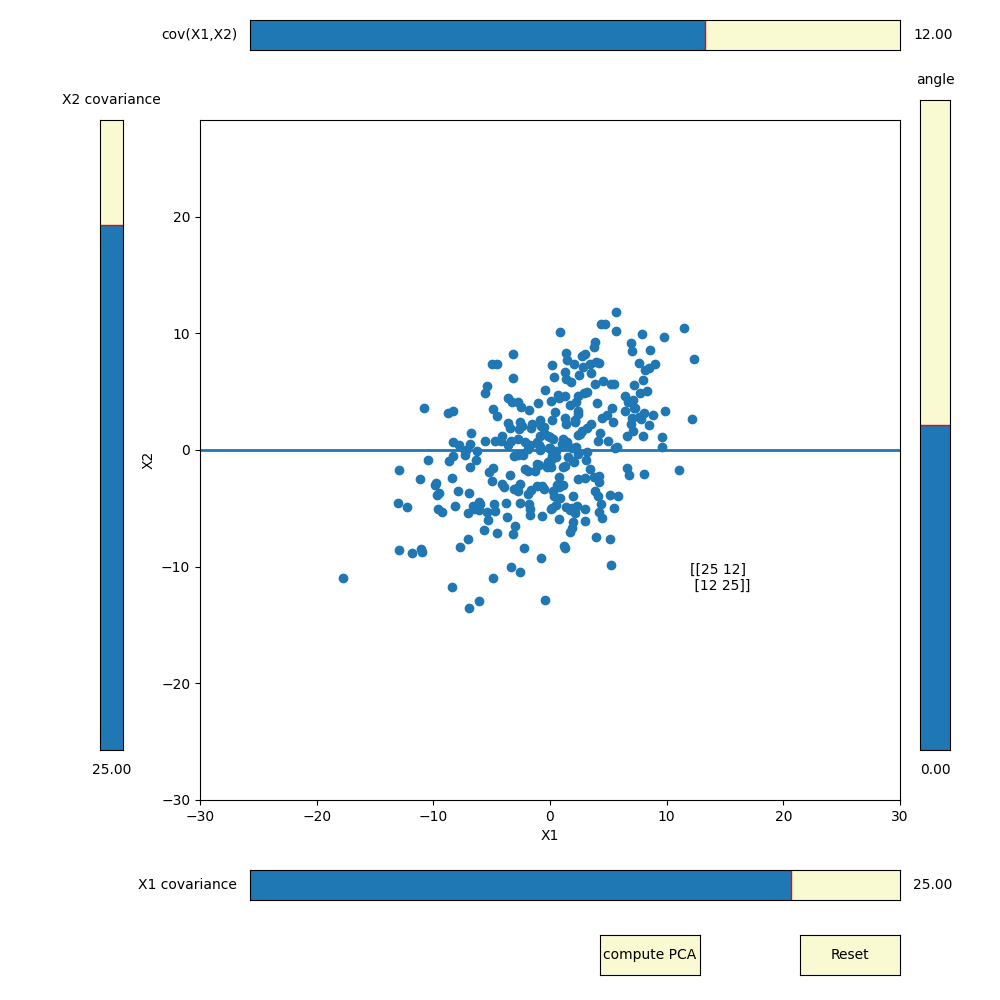

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
from ipywidgets import interact
%matplotlib notebook

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd



def f(sigma_1, sigma_2, sigma_cross, n_samples=300):
    ### f(sigma_1, sigma_2, sigma_cross, n_samples=300)
    ### sigma_1 : cov(X1, X1), sigma_2 : cov(X2, X2), sigma_cross=cov(X1, X2)=cov(X2, X1), n_samples: number of samples to draw
    #### a bivariate gaussian distribution sampling function

    # number of dimensions
    d = 2
    # covoriance matrix
    K = np.array([[sigma_1, sigma_cross], \
                  [sigma_cross, sigma_2]])
    # zero mean (=> simpler for the "game" to find the projection angle bellow)
    mu = np.array([0.0, 0.0])
    # sampling from a bivariate (d=2) gaussian distribution
    # by applying the lower-triangular matrix L to make x follow the distribution implied by the covariance matrix
    L = np.linalg.cholesky(K + 1e-6*np.eye(d))
    u = np.random.normal(size=(d, n_samples))
    x = np.dot(L, u)
    # unused because of zero mean
    # x[0, :] = mu[0] + x[0, :]
    # x[1, :] = mu[1] + x[1, :]

    return x, K



# The projection function to plot the projected points on the principal direction
def project_method2(data, angle):
    a = np.tan(angle  * np.pi / 180) # the line has equation y = a * x
    e = np.array([[1, a]]) # vector e is along the principal direction
    data_p = (np.dot(data.T, e.T)/np.dot(e, e.T))*e # projection by scalar product amplitude along direction of vector e.
    return data_p.T

def get_line(t, angle):
    a = np.tan(angle  * np.pi / 180)
    y = a * t
    return y

# Define initial parameters
init_X1_cov = 25
init_X2_cov = 25
init_cross_cov = 12
init_angle = 0

# Create the figure
fig, ax = plt.subplots(figsize=(10,10))
plt.xlim(-20,20)
plt.ylim(-20,20)
# create and scatter bivariate gaussian distributed data (also retrieve the covariance matrix)
data, K = f(init_X1_cov, init_X2_cov, init_cross_cov)
sc = ax.scatter(data[0, :], data[1, :])
# display the covariance matrix on the figure
t1 = ax.text(12, -12,  str(np.round(K, 1)))
# display the projection line
t = np.linspace(-30, 30, 1000)
line, = ax.plot(t, get_line(t, init_angle), lw=2)
# set axis
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.axis('equal')
# draw
plt.draw()

axcolor = 'lightgoldenrodyellow'
ax.margins(x=0)

# adjust the main plot to make room for the sliders
plt.subplots_adjust(left=0.20, bottom=0.20)

# Make a bottom horizontal slider to control the X1 correlation.
ax_X1_cov = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)
X1_cov_slider = Slider(
    ax=ax_X1_cov,
    label='X1 covariance',
    valmin=0.1,
    valmax=30,
    valinit=init_X1_cov,
)

# Make a vertically oriented slider to control the X2 correlation
ax_X2_cov = plt.axes([0.1, 0.25, 0.0225, 0.63], facecolor=axcolor)
X2_cov_slider = Slider(
    ax=ax_X2_cov,
    label="X2 covariance",
    valmin=0.1,
    valmax=30,
    valinit=init_X2_cov,
    orientation="vertical"
)

# Make a top horizontal slider to control the cross correlation.
ax_cross_cov = plt.axes([0.25, 0.95, 0.65, 0.03], facecolor=axcolor)
cross_cov_slider = Slider(
    ax=ax_cross_cov,
    label='cov(X1,X2)',
    valmin=-30,
    valmax=30,
    valinit=init_cross_cov,
)


# Make a top vertical slider to control the projection angle
ax_angle = plt.axes([0.92, 0.25, 0.03, 0.65], facecolor=axcolor)
angle_slider = Slider(
    ax=ax_angle,
    label='angle',
    valmin=-89,
    valmax=89,
    valinit=init_angle,
    orientation="vertical"
)


# The function to be called anytime a slider's value changes
def update(val):
    global fig, data, K, t1, data2, t, line, init_flag_pca, init_flag_projection, sc_update_projection, sc_update_pca, ax, sc
    data, K = f(X1_cov_slider.val, X2_cov_slider.val, cross_cov_slider.val)
    data2 = data

    sc.set_offsets(data.T)
    data_p_2 = project_method2(data, angle_slider.val)
    line.set_ydata(get_line(t, angle_slider.val))
    t1.set_text(str(np.round(K, 1)))

    if init_flag_projection == 0:
        sc_update_projection.set_offsets(data_p_2.T)

    if init_flag_pca==0:
        X=data2.T
        pca.fit(X)
        X_pca_1d = pca.transform(X)
        X_new = pca.inverse_transform(X_pca_1d)
        sc_update_pca.set_offsets(X_new)
    fig.canvas.draw_idle()



# The function to be called anytime a slider's value changes
def update_no_new_sampling(val):
    global fig, data, K, t1, data2, t, line, init_flag_pca, init_flag_projection, sc_update_projection, sc_update_pca, ax

    line.set_ydata(get_line(t, angle_slider.val))
    data_p_2 = project_method2(data, angle_slider.val)
    if init_flag_projection:
        sc_update_projection = ax.scatter(data_p_2[0, :], data_p_2[1, :], alpha=0.9,color='orange')
        init_flag_projection=0
    else:
        sc_update_projection.set_offsets(data_p_2.T)
        sc_update_projection.set_visible(True)

    fig.canvas.draw_idle()


# register the update function with each slider
cross_cov_slider.on_changed(update)
X2_cov_slider.on_changed(update)
X1_cov_slider.on_changed(update)
angle_slider.on_changed(update_no_new_sampling)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
button_reset = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')
pca_btn_ax = plt.axes([0.6, 0.025, 0.1, 0.04])
button_PCA = Button(pca_btn_ax, 'compute PCA', color=axcolor, hovercolor='0.975')


pca = PCA(n_components=1)
init_flag_pca = 1
init_flag_projection = 1

def button_PCA_callback(event):
    global data, data2, t, line, init_flag_pca, init_flag_projection, sc_update_projection, sc_update_pca, sc


    data2 = data
    X=data2.T
    pca.fit(X)
    X_pca_1d = pca.transform(X)
    X_new = pca.inverse_transform(X_pca_1d)

    data_p_2 = project_method2(data, angle_slider.val)

    if init_flag_pca:
        sc_update_pca = ax.scatter(X_new[:, 0], X_new[:, 1], alpha=0.9,color='y')
        init_flag_pca = 0
    else:
        sc_update_pca.set_offsets(X_new)
        sc_update_pca.set_visible(True)

    if init_flag_projection:
        sc_update_projection = ax.scatter(data_p_2[:, 0], data_p_2[:, 1], alpha=0.9,color='orange')
        line.set_ydata(get_line(t, angle_slider.val))
        init_flag_projection = 0
    else:
        sc_update_projection.set_offsets(data_p_2.T)
        sc_update_projection.set_visible(True)
        line.set_ydata(get_line(t, angle_slider.val))
    fig.canvas.draw_idle()



def button_reset_callback(event):
    global fig, data, K, t1, data2, t, line, init_flag_pca, init_flag_projection, sc_update_projection, sc_update_pca, ax
    # ax.clear()

    X1_cov_slider.reset()
    X2_cov_slider.reset()
    cross_cov_slider.reset()
    angle_slider.reset()

    # fill the figure again
    # create and scatter bivariate gaussian distributed data (also retrieve the covariance matrix)
    data, K = f(X1_cov_slider.val, X2_cov_slider.val, cross_cov_slider.val)
    sc.set_offsets(data.T)
    sc_update_projection.set_visible(False)
    sc_update_pca.set_visible(False)
    # display the projection line
    line.set_ydata(get_line(t, angle_slider.val))
    # display the covariance matrix on the figure
    t1.set_text(str(np.round(K, 1)))

    ax.axis('equal')
    # draw
    fig.canvas.draw_idle()


button_reset.on_clicked(button_reset_callback)
button_PCA.on_clicked(button_PCA_callback)

plt.show()


<IPython.core.display.Javascript object>


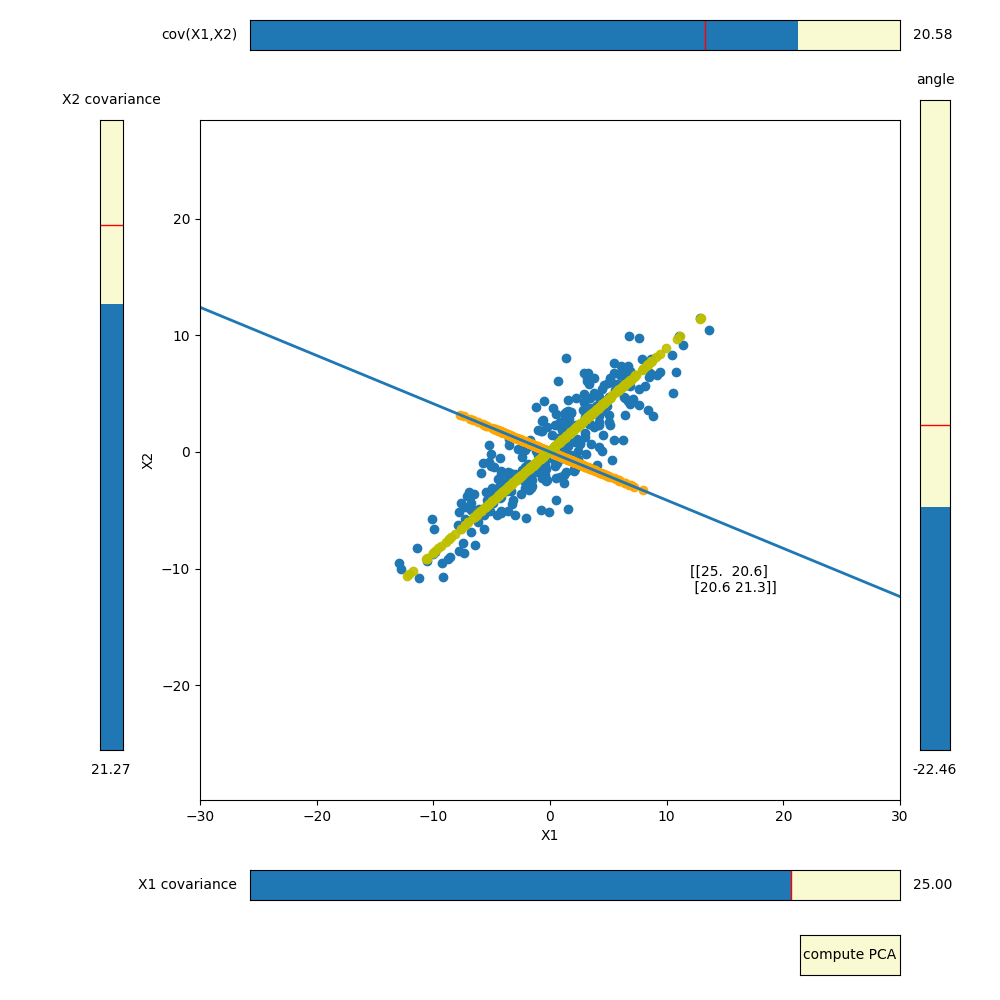

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
from ipywidgets import interact
%matplotlib notebook

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
global data2
def f(sigma_1, sigma_2, sigma_cross, n_samples=300):
    ### f(sigma_1, sigma_2, sigma_cross, n_samples=300)
    ### sigma_1 : cov(X1, X1), sigma_2 : cov(X2, X2), sigma_cross=cov(X1, X2)=cov(X2, X1), n_samples: number of samples to draw
    #### a bivariate gaussian distribution sampling function

    # number of dimensions
    d = 2
    # covoriance matrix
    K = np.array([[sigma_1, sigma_cross], \
                  [sigma_cross, sigma_2]])
    # zero mean (=> simpler for the "game" to find the projection angle bellow)
    mu = np.array([0.0, 0.0])
    # sampling from a bivariate (d=2) gaussian distribution
    # by applying the lower-triangular matrix L to make x follow the distribution implied by the covariance matrix
    L = np.linalg.cholesky(K + 1e-6*np.eye(d))
    u = np.random.normal(size=(d, n_samples))
    x = np.dot(L, u)
    # unused because of zero mean
    # x[0, :] = mu[0] + x[0, :]
    # x[1, :] = mu[1] + x[1, :]

    return x, K



# The projection function to plot the projected points on the principal direction
def project_method2(data, angle):
    a = np.tan(angle  * np.pi / 180) # the line has equation y = a * x
    e = np.array([[1, a]]) # vector e is along the principal direction
    data_p = (np.dot(data.T, e.T)/np.dot(e, e.T))*e # projection by scalar product amplitude along direction of vector e.
    return data_p.T

def get_line(t, angle):
    a = np.tan(angle  * np.pi / 180)
    y = a * t
    return y

# Define initial parameters
init_X1_cov = 25
init_X2_cov = 25
init_cross_cov = 12
init_angle = 0

# Create the figure
fig, ax = plt.subplots(figsize=(10,10))
plt.xlim(-20,20)
plt.ylim(-20,20)
# create and scatter bivariate gaussian distributed data (also retrieve the covariance matrix)
data, K = f(init_X1_cov, init_X2_cov, init_cross_cov)
sc = ax.scatter(data[0, :], data[1, :])
# display the covariance matrix on the figure
t1 = ax.text(12, -12,  str(np.round(K, 1)))
# display the projection line
t = np.linspace(-30, 30, 1000)
line, = ax.plot(t, get_line(t, init_angle), lw=2)
# set axis
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.axis('equal')
# draw
plt.draw()

axcolor = 'lightgoldenrodyellow'
ax.margins(x=0)

# adjust the main plot to make room for the sliders
plt.subplots_adjust(left=0.20, bottom=0.20)

# Make a bottom horizontal slider to control the X1 correlation.
ax_X1_cov = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)
X1_cov_slider = Slider(
    ax=ax_X1_cov,
    label='X1 covariance',
    valmin=0.1,
    valmax=30,
    valinit=init_X1_cov,
)

# Make a vertically oriented slider to control the X2 correlation
ax_X2_cov = plt.axes([0.1, 0.25, 0.0225, 0.63], facecolor=axcolor)
X2_cov_slider = Slider(
    ax=ax_X2_cov,
    label="X2 covariance",
    valmin=0.1,
    valmax=30,
    valinit=init_X2_cov,
    orientation="vertical"
)

# Make a top horizontal slider to control the cross correlation.
ax_cross_cov = plt.axes([0.25, 0.95, 0.65, 0.03], facecolor=axcolor)
cross_cov_slider = Slider(
    ax=ax_cross_cov,
    label='cov(X1,X2)',
    valmin=-30,
    valmax=30,
    valinit=init_cross_cov,
)


# Make a top vertical slider to control the projection angle
ax_angle = plt.axes([0.92, 0.25, 0.03, 0.65], facecolor=axcolor)
angle_slider = Slider(
    ax=ax_angle,
    label='angle',
    valmin=-89,
    valmax=89,
    valinit=init_angle,
    orientation="vertical"
)


# The function to be called anytime a slider's value changes
def update(val):
    global data, data2, sc_update_projection, sc_update_pca, data_p_2, line, K
    data, K = f(X1_cov_slider.val, X2_cov_slider.val, cross_cov_slider.val)
    data2 = data

    sc.set_offsets(data.T)
    data_p_2 = project_method2(data, angle_slider.val)
    line.set_ydata(get_line(t, angle_slider.val))
    t1.set_text(str(np.round(K, 1)))

    if init_flag_projection == 0:
        sc_update_projection.set_offsets(data_p_2.T)

    if init_flag_pca==0:
        X=data2.T
        pca.fit(X)
        X_pca_1d = pca.transform(X)
        X_new = pca.inverse_transform(X_pca_1d)
        sc_update_pca.set_offsets(X_new)
    fig.canvas.draw_idle()



# The function to be called anytime a slider's value changes
def update_no_new_sampling(val):
    global data, data2, sc_update_projection, sc_update_pca, data_p_2, line, init_flag_projection
    data_p_2 = project_method2(data, angle_slider.val)
    line.set_ydata(get_line(t, angle_slider.val))

    data_p_2 = project_method2(data, angle_slider.val)
    if init_flag_projection:
        sc_update_projection = ax.scatter(data_p_2[:, 0], data_p_2[:, 1], alpha=0.9,color='orange')
        init_flag_projection=0
    else:
        sc_update_projection.set_offsets(data_p_2.T)

    fig.canvas.draw_idle()


# register the update function with each slider
cross_cov_slider.on_changed(update)
X2_cov_slider.on_changed(update)
X1_cov_slider.on_changed(update)
angle_slider.on_changed(update_no_new_sampling)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'compute PCA', color=axcolor, hovercolor='0.975')


pca = PCA(n_components=1)
init_flag_pca = 1
init_flag_projection = 1

def reset(event):
    global data, data2, t, line, init_flag_pca, init_flag_projection, sc_update_projection, sc_update_pca


    data2 = data
    X=data2.T
    pca.fit(X)
    X_pca_1d = pca.transform(X)
    X_new = pca.inverse_transform(X_pca_1d)

    data_p_2 = project_method2(data, angle_slider.val)

    if init_flag_pca:
        sc_update_pca = ax.scatter(X_new[:, 0], X_new[:, 1], alpha=0.9,color='y')
        init_flag_pca = 0
    else:
        sc_update_pca.set_offsets(X_new)

    if init_flag_projection:
        sc_update_projection = ax.scatter(data_p_2[:, 0], data_p_2[:, 1], alpha=0.9,color='orange')
        line.set_ydata(get_line(t, angle_slider.val))
        init_flag_projection = 0
    else:
        sc_update_projection.set_offsets(data_p_2.T)
        line.set_ydata(get_line(t, angle_slider.val))
    fig.canvas.draw_idle()



button.on_clicked(reset)


plt.show()


<IPython.core.display.Javascript object>


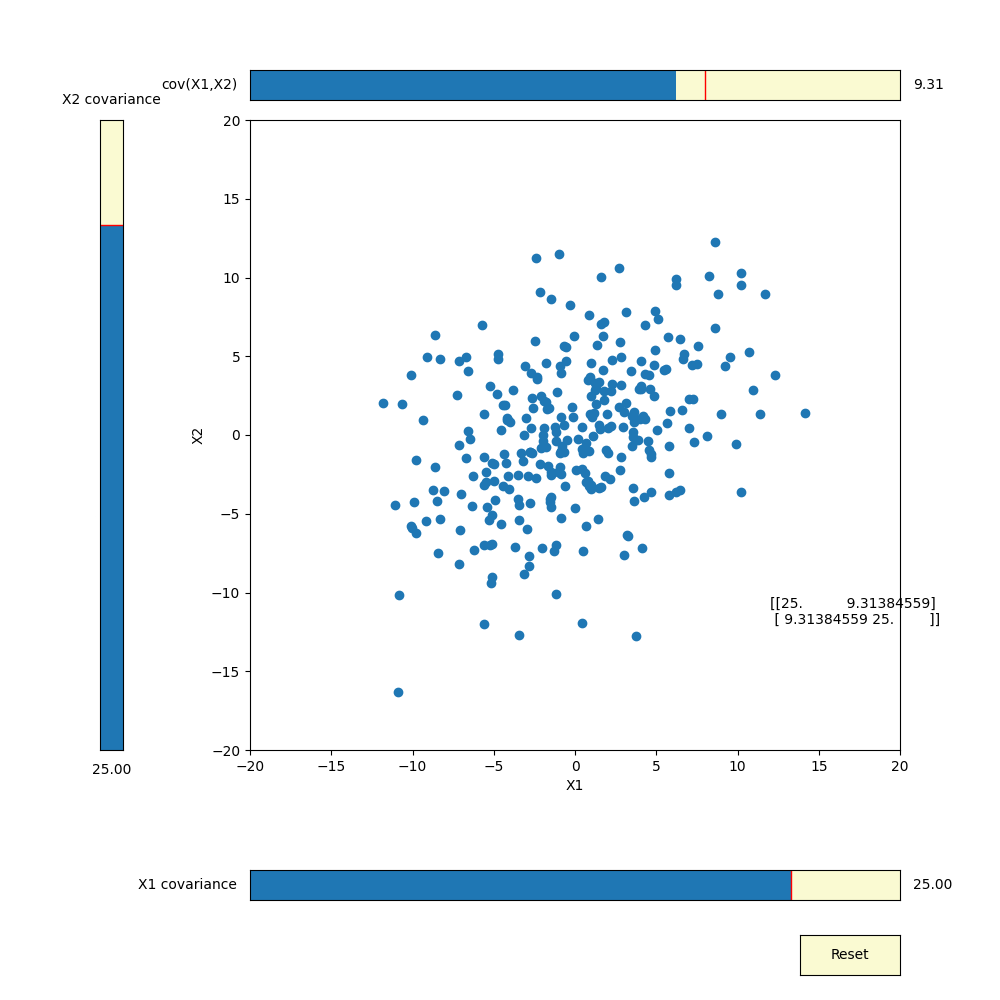

(2, 300)


In [50]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
from ipywidgets import interact
%matplotlib notebook

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

def f(sigma_1, sigma_2, sigma_cross, n_samples=300):
    ### f(sigma_1, sigma_2, sigma_cross, n_samples=300)
    ### sigma_1 : cov(X1, X1), sigma_2 : cov(X2, X2), sigma_cross=cov(X1, X2)=cov(X2, X1), n_samples: number of samples to draw
    #### a bivariate gaussian distribution sampling function
    
    # number of dimensions
    d = 2
    # covoriance matrix
    K = np.array([[sigma_1, sigma_cross], \
                  [sigma_cross, sigma_2]])    
    # zero mean (=> simpler for the "game" to find the projection angle bellow)
    mu = np.array([0.0, 0.0])
    # sampling from a bivariate (d=2) gaussian distribution
    # by applying the lower-triangular matrix L to make x follow the distribution implied by the covariance matrix
    L = np.linalg.cholesky(K + 1e-6*np.eye(d))
    u = np.random.normal(size=(d, n_samples))
    x = np.dot(L, u)
    # unused because of zero mean
    # x[0, :] = mu[0] + x[0, :]
    # x[1, :] = mu[1] + x[1, :]

    return x, K

# Define initial parameters
init_X1_cov = 25
init_X2_cov = 25
init_cross_cov = 12
# Create the figure and the line that we will manipulate
fig, ax = plt.subplots(figsize=(10,10))
data, K = f(init_X1_cov, init_X2_cov, init_cross_cov)
print(data.shape)
sc = ax.scatter(data[0, :], data[1, :])
plt.xlim(-20,20)
plt.ylim(-20,20)
#line, = plt.plot(t, f(t, init_amplitude, init_frequency), lw=2)
ax.set_xlabel('X1')
ax.set_ylabel('X2')

t1 = ax.text(12, -12,  str(K))

plt.draw()

axcolor = 'lightgoldenrodyellow'
ax.margins(x=0)

# adjust the main plot to make room for the sliders
plt.subplots_adjust(left=0.25, bottom=0.25)

# Make a bottom horizontal slider to control the X1 correlation.
ax_X1_cov = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)
X1_cov_slider = Slider(
    ax=ax_X1_cov,
    label='X1 covariance',
    valmin=0.1,
    valmax=30,
    valinit=init_X1_cov,
)

# Make a vertically oriented slider to control the X2 correlation
ax_X2_cov = plt.axes([0.1, 0.25, 0.0225, 0.63], facecolor=axcolor)
X2_cov_slider = Slider(
    ax=ax_X2_cov,
    label="X2 covariance",
    valmin=0.1,
    valmax=30,
    valinit=init_X2_cov,
    orientation="vertical"
)

# Make a top horizontal slider to control the cross correlation.
ax_cross_cov = plt.axes([0.25, 0.9, 0.65, 0.03], facecolor=axcolor)
cross_cov_slider = Slider(
    ax=ax_cross_cov,
    label='cov(X1,X2)',
    valmin=-30,
    valmax=30,
    valinit=init_cross_cov,
)


# The function to be called anytime a slider's value changes
def update(val):
    data, K = f(X1_cov_slider.val, X2_cov_slider.val, cross_cov_slider.val)
    print(data.shape)
    sc.set_offsets(data.T)
    t1.set_text(str(K))
       
    
    fig.canvas.draw_idle()


# register the update function with each slider
cross_cov_slider.on_changed(update)
X2_cov_slider.on_changed(update)
X1_cov_slider.on_changed(update)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')


def reset(event):
    cross_cov_slider.reset()
    X1_cov_slider.reset()
    X2_cov_slider.reset()
button.on_clicked(reset)


plt.show()


In [12]:
# import ipywidgets.interact class, this class will represent a slide bar.
from ipywidgets import interact
# use interact decorator to decorate the function, so the function can receive the slide bar's value with parameter x.
@interact(x=(0, 100))
def double_number(x):
    print("The double of %d is %d." % (x, x*2))
    
# add another slide bar to this function with the interact decorator.    
@interact(y=(0, 10))
def square_number(y):
    print("The square of %d is %d." % (y, y**2))

interactive(children=(IntSlider(value=50, description='x'), Output()), _dom_classes=('widget-interact',))

interactive(children=(IntSlider(value=5, description='y', max=10), Output()), _dom_classes=('widget-interact',…

In [13]:

L_0 = np.linalg.cholesky(K_0 + 1e-6*np.eye(d))
print(L_0)


# generate random samples from a multivariate gaussian distribution (d Dimensions)
n_samples = 600
u0 = np.random.normal(size=(d, n_samples))

# apply the L (lower-triangular matrix) to make x follow the distribution implied by the covariance matrix
x0 = np.dot(L_0, u0)

x0[0, :] += mu_0[0]
x0[1, :] += mu_0[1]





labels = np.zeros(np.size(x0[0, :]))
data= x0.T

fig = px.scatter(data, x=0, y=1, color=labels)
fig.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1,
  )
fig.show()

[[7.10633527 0.        ]
 [6.96561562 1.40719579]]


In [14]:
# generate random samples from a multivariate gaussian distribution (d Dimensions)
n_samples = 300
d=3
u0 = np.random.normal(size=(d, n_samples))
u0 = u0.T 
uones= np.ones((len(u0), 1))
print(uones.shape)


u0 = np.hstack((u0, uones))
print(u0.shape)


# rotation 
#theta0 = 45/180 * np.pi
#rotation_matrix = np.array([[np.cos(theta0), -np.sin(theta0)], \
 #             [np.sin(theta0), np.cos(theta0)]])
# scaling 
S = np.array([[10, 0, 0, 0], \
                               [0, 5, 0, 0],\
              [0, 0, 1, 0], \
             [0, 0, 0, 1]])

#T = rotation_matrix @ S

#only scaling for now
T = S


x0 = np.dot(u0, T)

mu_0 = np.array([100.0, 100.0, 1000])

x0[:, 0] += mu_0[0]
x0[:, 1] += mu_0[1]
x0[:, 2] += mu_0[2]






labels = np.zeros(np.size(x0[0, :]))
data= x0



X = data[:,:3]
print(X.shape)

#fig = px.scatter_3d(
#    X, x=0, y=1, z=2
#)
#fig.show()

(300, 1)
(300, 4)
(300, 3)


In [18]:
import numpy as np
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.preprocessing import StandardScaler
import pandas as pd
from matplotlib import pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
%matplotlib notebook


d = 2
mu_0 = np.array([00.0, 00.0])


# rotation
theta0 = 0/180 * np.pi

rotation_matrix = np.array([[np.cos(theta0), -np.sin(theta0)], \
              [np.sin(theta0), np.cos(theta0)]])

#print(rotation_matrix)
# scaling
S = scaling_matrix = np.array([[10, 0], \
              [0, 1]])
#print(S)

T = rotation_matrix @ S

#print(T)

K_0 = T @ T.T

print(K_0)


# generate random samples from a multivariate gaussian distribution (d Dimensions)
n_samples = 300
u0 = np.random.normal(size=(d, n_samples))

x0 = np.dot(T, u0)

x0[0, :] += mu_0[0]
x0[1, :] += mu_0[1]





labels = np.zeros(np.size(x0[0, :]))
data= x0
print(data.shape)

[[100.   0.]
 [  0.   1.]]
(2, 300)


<IPython.core.display.Javascript object>


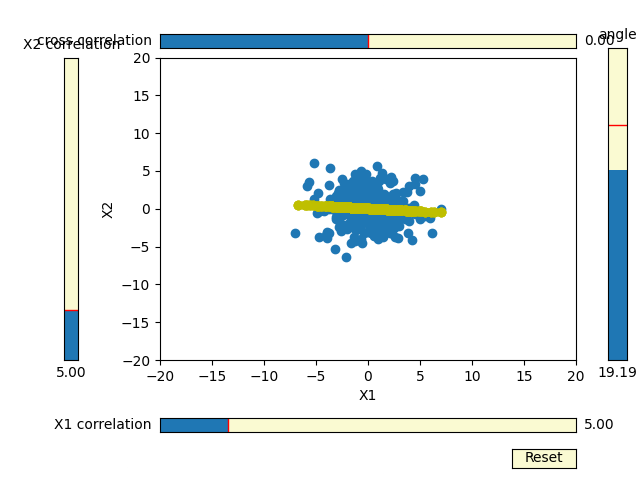

[[5 0]
 [0 5]]
(2, 300)


In [60]:
import numpy as np
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.preprocessing import StandardScaler
import pandas as pd
from matplotlib import pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
# import ipywidgets.interact class, this class will represent a slide bar.
from ipywidgets import interact
%matplotlib notebook


global data2

# The parametrized function to be plotted
def f(sigma_1, sigma_2, sigma_cross, n_samples=300):

    d = 2
    K = np.array([[sigma_1, sigma_cross], \
                  [sigma_cross, sigma_2]])
    print(K)

    #
    L = np.linalg.cholesky(K + 1e-6*np.eye(d))

    mu = np.array([0.0, 0.0])

    # generate random samples from a multivariate gaussian distribution (d Dimensions)

    u = np.random.normal(size=(d, n_samples))

    # apply the L (lower-triangular matrix) to make x follow the distribution implied by the covariance matrix
    x = np.dot(L, u)
    x[0, :] = mu[0] + x[0, :]
    x[1, :] = mu[1] + x[1, :]

    return x

# The parametrized function to be plotted
def project_method2(data, angle):
    a = np.tan(angle  * np.pi / 180)
    e = np.array([[1, a]])
    # scal_prods = np.dot(e, data)
    # x_p = scal_prods * np.cos(angle * np.pi / 180)
    # y_p = scal_prods * np.sin(angle * np.pi / 180)
    data_p = (np.dot(data.T, e.T)/np.dot(e, e.T))*e

    # data_p = np.vstack((x_p, y_p))
    # print("data_p.shape method2", data_p.shape)
    return data_p.T



def get_line(t, angle):
    a = np.tan(angle  * np.pi / 180)
    y = a * t
    return y

# Define initial parameters
init_X1_corr = 5
init_X2_corr = 5
init_cross_corr = 0
init_angle = 45


# Create the figure and the line that we will manipulate
fig, ax = plt.subplots()
data = f(init_X1_corr, init_X2_corr, init_cross_corr)
print(data.shape)
sc = ax.scatter(data[0, :], data[1, :])
plt.xlim(-20,20)
plt.ylim(-20,20)
#line, = plt.plot(t, f(t, init_amplitude, init_frequency), lw=2)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
plt.draw()

axcolor = 'lightgoldenrodyellow'
ax.margins(x=0)

# adjust the main plot to make room for the sliders
plt.subplots_adjust(left=0.25, bottom=0.25)

# Make a bottom horizontal slider to control the X1 correlation.
ax_X1_corr = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)
X1_corr_slider = Slider(
    ax=ax_X1_corr,
    label='X1 correlation',
    valmin=0.1,
    valmax=30,
    valinit=init_X1_corr,
)

# Make a vertically oriented slider to control the X2 correlation
ax_X2_corr = plt.axes([0.1, 0.25, 0.0225, 0.63], facecolor=axcolor)
X2_corr_slider = Slider(
    ax=ax_X2_corr,
    label="X2 correlation",
    valmin=0.1,
    valmax=30,
    valinit=init_X2_corr,
    orientation="vertical"
)

# Make a top horizontal slider to control the cross correlation.
ax_cross_corr = plt.axes([0.25, 0.9, 0.65, 0.03], facecolor=axcolor)
cross_corr_slider = Slider(
    ax=ax_cross_corr,
    label='cross correlation',
    valmin=-30,
    valmax=30,
    valinit=init_cross_corr,
)

# Make a top vertical slider to control the projection angle
ax_angle = plt.axes([0.95, 0.25, 0.03, 0.65], facecolor=axcolor)
angle_slider = Slider(
    ax=ax_angle,
    label='angle',
    valmin=-89,
    valmax=89,
    valinit=init_angle,
    orientation="vertical"
)



# The function to be called anytime a slider's value changes
def update(val):
    data = f(X1_corr_slider.val, X2_corr_slider.val, cross_corr_slider.val)
    global data2
    data2 = data
    print(data.shape)
    print(data[:,0])
    sc.set_offsets(data.T)
    fig.canvas.draw_idle()


# register the update function with each slider
cross_corr_slider.on_changed(update)
X2_corr_slider.on_changed(update)
X1_corr_slider.on_changed(update)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')


pca = PCA(n_components=1)
init_flag = 1

def reset(event):
    global data2, t, line,init_flag
    data2 = data
    
    X=data2.T
    pca.fit(X)
    X_pca_1d = pca.transform(X)
    X_new = pca.inverse_transform(X_pca_1d)
    if init_flag:        
        sc_update_pca = ax.scatter(X_new[:, 0], X_new[:, 1], alpha=0.9,color='y')
        data_p_2 = project_method2(data, angle_slider.val)
        sc_update_p = ax.scatter(X_new[:, 0], X_new[:, 1], alpha=0.9,color='y')
        # Create the line that we will manipulate
        t = np.linspace(-40, 40, 1000)
        line, = plt.plot(t, f(t, init_angle), lw=2)
        init_flag = 0
    else:        
        data_p_2 = project_method2(data, angle_slider.val)
        sc_update_p.set_offsets(data_p_2.T)
        sc_update_pca.set_offsets(X_new)
        line.set_ydata(get_line(t, angle_slider.val))
    fig.canvas.draw_idle()

  
    
    
button.on_clicked(reset)


plt.show()



In [19]:
global data2
data2

array([[-2.32388663e-01, -3.62672323e+00, -1.15503412e+01,
         4.67271764e+00,  5.77067417e+00,  3.41344513e+00,
        -3.98035761e-01, -9.78045238e+00, -3.17603291e+00,
         5.42328328e+00, -9.32970945e+00, -2.82416279e+00,
        -1.13255672e+00,  4.45707437e+00, -3.10974861e-02,
         5.90344648e+00, -8.95100061e+00, -2.54917994e+00,
        -5.31432623e+00, -1.90704251e+00, -7.98234745e+00,
         1.95049472e+00, -5.89080838e-01, -4.46277520e+00,
         2.52712610e+00, -6.48674432e+00, -2.23389426e+00,
        -6.59100150e+00, -1.20822785e+01, -6.04719957e+00,
        -9.74573464e-02, -2.48258531e+00,  1.18472790e+00,
        -3.90684504e+00, -2.13116427e+00, -6.12219731e+00,
         5.47933793e+00, -2.33097354e+00,  2.39432557e+00,
        -1.41411027e-01, -6.35217985e+00,  2.43088999e+00,
        -1.32198812e+00,  4.97272178e+00,  1.58098038e+00,
         2.26212297e+00, -8.80697847e+00,  2.34727566e+00,
        -5.83296670e-01,  6.75538206e+00,  3.43565155e+0

<IPython.core.display.Javascript object>


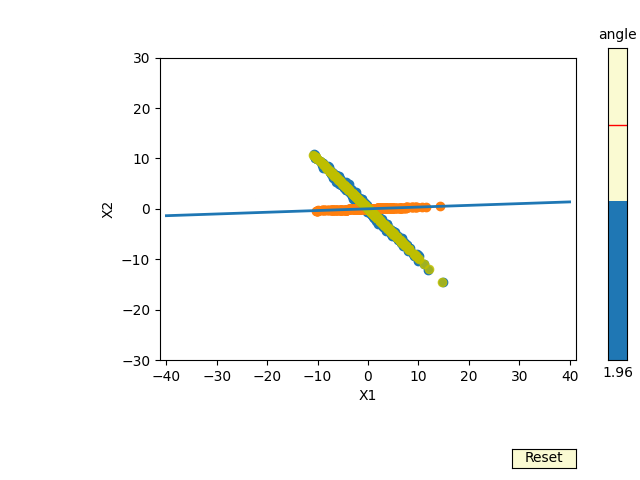

original shape:    (300, 2)
transformed shape: (300, 1)
[ 2.27286116 -1.70264339]


In [54]:


def f(t, angle):
    a = np.tan(angle  * np.pi / 180)
    y = a * t
    return y

# The parametrized function to be plotted
def project(data, angle):
    a = np.tan(angle  * np.pi / 180)
    x = data[0, :]
    y = data[1, :]

    x_p = (x + a * y) / (1 + a**2)
    y_p = a * x_p

    data_p = np.vstack((x_p, y_p))
    print(a)
    print(data_p.shape)
    return data_p

# The parametrized function to be plotted
def project_method2(data, angle):
    a = np.tan(angle  * np.pi / 180)
    e = np.array([[1, a]])
    # scal_prods = np.dot(e, data)
    # x_p = scal_prods * np.cos(angle * np.pi / 180)
    # y_p = scal_prods * np.sin(angle * np.pi / 180)
    data_p = (np.dot(data.T, e.T)/np.dot(e, e.T))*e

    # data_p = np.vstack((x_p, y_p))
    # print("data_p.shape method2", data_p.shape)
    return data_p.T



global data2
data = data2

# Define initial parameters
init_angle = 45

# Create the figure and the line that we will manipulate
fig, ax = plt.subplots()
sc = ax.scatter(data[0, :], data[1, :])
ax.axis('equal')
# sc_update = ax.scatter(data[0, :], data[1, :])
sc_update2 = ax.scatter(data[0, :], data[1, :])
plt.xlim(-30,30)
plt.ylim(-30,30)
#line, = plt.plot(t, f(t, init_amplitude, init_frequency), lw=2)
ax.set_xlabel('X1')
ax.set_ylabel('X2')


pca = PCA(n_components=1)
X=data2.T
pca.fit(X)
X_pca_1d = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca_1d.shape)
X_new = pca.inverse_transform(X_pca_1d)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8,color='y')






t = np.linspace(-40, 40, 1000)

# Define initial parameters
init_amplitude = 5
init_frequency = 3

# Create the figure and the line that we will manipulate
line, = plt.plot(t, f(t, init_angle), lw=2)


plt.draw()

axcolor = 'lightgoldenrodyellow'
ax.margins(x=0)

# adjust the main plot to make room for the sliders
plt.subplots_adjust(left=0.25, bottom=0.25)

# Make a top vertical slider to control the projection angle
ax_angle = plt.axes([0.95, 0.25, 0.03, 0.65], facecolor=axcolor)
angle_slider = Slider(
    ax=ax_angle,
    label='angle',
    valmin=-89,
    valmax=89,
    valinit=init_angle,
    orientation="vertical"
)

# https://stackoverflow.com/questions/42722691/python-matplotlib-update-scatter-plot-from-a-function
# The function to be called anytime a slider's value changes
def update(val):
    # data_p = project(data, angle_slider.val)
    # print(data_p.shape)
    # sc_update.set_offsets(data_p.T)

    data_p_2 = project_method2(data, angle_slider.val)
    sc_update2.set_offsets(data_p_2.T)

    line.set_ydata(f(t, angle_slider.val))
    fig.canvas.draw_idle()


# register the update function with each slider
angle_slider.on_changed(update)


# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')


def reset(event):
    angle_slider.reset()
    print("reseted")
button.on_clicked(reset)


plt.show()
print(data[:,0])


array([[-1.79626156e+00, -9.27588822e-02,  2.90559588e+00,
         3.86186788e+00, -3.22548365e+00,  1.30433083e-01,
        -2.89526644e+00, -2.28888873e-01, -2.26576654e+00,
        -9.91384715e-01, -2.62234274e+00,  1.19991085e+00,
         1.69240465e+00,  3.43370054e+00, -4.38035214e+00,
        -6.71794049e-01,  2.90973797e+00,  7.64758614e-02,
        -3.39047222e+00,  5.48669730e-01,  2.09913937e+00,
        -4.63317980e-01, -1.07886700e+00, -2.00247451e+00,
        -1.63913912e+00,  1.25515884e+00,  2.66360430e+00,
        -2.13489461e+00,  1.53088548e+00, -3.45631795e+00,
        -2.18160403e+00, -2.35169331e+00,  3.17518442e+00,
        -5.19242154e-01, -1.89968046e-01, -1.01095944e+00,
        -4.13458203e+00, -2.70073952e+00, -1.49276265e+00,
        -4.31425053e-01, -1.68508720e+00, -7.37358517e-01,
        -1.78206668e+00, -1.32503837e+00, -5.75541119e+00,
        -3.63452941e-01, -8.88576255e-01, -1.34111830e+00,
        -1.56660175e+00, -2.61155951e+00,  5.05550782e-0

original shape:    (300, 2)
transformed shape: (300, 1)


<IPython.core.display.Javascript object>


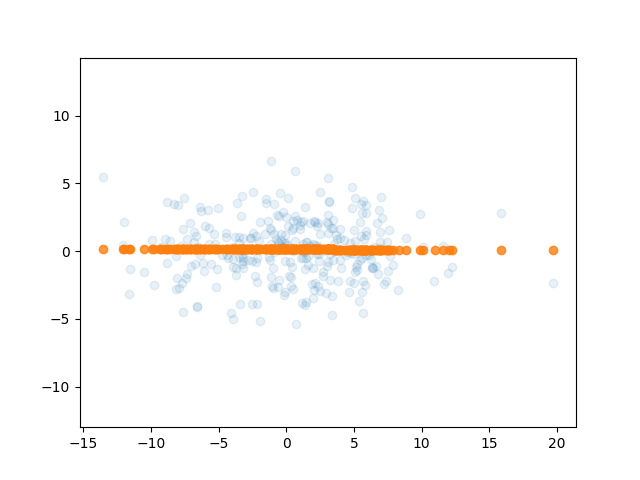

In [35]:
%matplotlib notebook
global data2
pca = PCA(n_components=1)
X=data2.T

pca.fit(X)
X_pca_1d = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca_1d.shape)
X_new = pca.inverse_transform(X_pca_1d)
plt.scatter(X[:, 0], X[:, 1], alpha=0.1)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');
